### Training RNN using World's data

This is based on `COVID-19 growth prediction using multivariate
long short term memory` by `Novanto Yudistira`

https://arxiv.org/pdf/2005.04809.pdf

https://github.com/VICS-CORE/lstmcorona/blob/master/lstm.py

- We've aligned all countries' inputs rather than taking an absolute timeline. We start when number of confirmed cases in the country has crossed 100.
- We've normalised data by dividing by a population factor. That way the network can learn what factor of population will be affected.
- Rather than using the entire timeline as an input as suggested by NYudistira, we're training a fixed window (e.g. 20 days) so that the model learns to predict the future by looking at present data. The problem with fixed window approach is that some countries have peaked, while others have not. Also few countries start early, and some start late.

#### Ideas
- One idea is to train a network to predict SIR buckets
- Another is to train only with most populous countries

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

from matplotlib.ticker import MultipleLocator

In [2]:
CUDA="cuda:0"
CPU="cpu"
device = torch.device(CUDA if torch.cuda.is_available() else CPU)
print(device)

cpu


In [3]:
# define paths
DATA_DIR = 'data'
MODELS_DIR = 'models'

### Colab only

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd 'drive/My Drive/CS/colab/'

### Read OWID data

In [ ]:
!head -n1 data/owid-covid-data.csv

In [4]:
cols = ['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'population']
dates = ['date']
df = pd.read_csv(DATA_DIR + "/owid-covid-data.csv", 
                 usecols=cols,
                 parse_dates=dates)
df.sample()

,location,date,total_cases,new_cases,total_deaths,new_deaths,population
4445,Costa Rica,2020-05-24,918,7,10,0,5094114.0


### LSTM

In [5]:
class YudistirNet(tnn.Module):
    def __init__(self, ip_seq_len=1, op_seq_len=1, hidden_size=1, num_layers=1):
        super(YudistirNet, self).__init__()
        
        self.ip_seq_len = ip_seq_len
        self.op_seq_len = op_seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = tnn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.linear = tnn.Linear(self.hidden_size * self.ip_seq_len, self.op_seq_len)
        self.sigmoid = tnn.Sigmoid()
    
    def forward(self, ip):
        lstm_out, _ = self.lstm(ip)
        linear_out = self.linear(lstm_out.view(self.hidden_size * self.ip_seq_len))
        sigmoid_out = self.sigmoid(linear_out.view(self.op_seq_len))
        return sigmoid_out
    
    def predict(self, ip):
        with torch.no_grad():
            preds = self.forward(ip)
        return preds

### Checkpoint methods

In [6]:
def save_checkpoint(epoch, model, optimizer, trn_losses, val_losses, min_val_loss, path=""):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'trn_losses': trn_losses,
        'val_losses': val_losses,
        'min_val_loss': min_val_loss
    }, path or MODELS_DIR + "/latest.pt")
    print("Checkpoint saved")
    
def load_checkpoint(path="", device="cpu"):
    cp = torch.load(path or MODELS_DIR + "/latest.pt", map_location=device)
    print("Checkpoint loaded")
    return cp['epoch'], cp['model_state_dict'], cp['optimizer_state_dict'], cp['trn_losses'], cp['val_losses'], cp.get('min_val_loss', np.Inf)

### Config

In [7]:
# config
IP_SEQ_LEN = 20
OP_SEQ_LEN = 10
VAL_RATIO = 0.3

HIDDEN_SIZE = 10
NUM_LAYERS = 4
LEARNING_RATE = 0.001
NUM_EPOCHS = 2001

model = YudistirNet(ip_seq_len=IP_SEQ_LEN, op_seq_len=OP_SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
model = model.to(device)

loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=LEARNING_RATE)

### Prepare dataset

In [ ]:
def gen_dataset():
    ip_trn = []
    op_trn = []

    countries = df['location'].unique()
    pop_countries = ['China', 'United States', 'Indonesia', 'Pakistan', 'Brazil', 'Bangladesh', 'Russia', 'Mexico']
    c = 0
    for country in countries:
        if country in ['World', 'International', 'India']: # Countries to be skipped
            continue
        country_df = df.loc[df.location == country]
        tot_cases_gt_100 = (country_df['total_cases'] >= 100)
        country_df = country_df.loc[tot_cases_gt_100]

        if len(country_df) >= IP_SEQ_LEN + OP_SEQ_LEN:
            c += 1
            pop = country_df['population'].iloc[0]
            print(c, country, len(country_df), pop)
            daily_cases = np.array(country_df['new_cases'].rolling(7, center=True, min_periods=1).mean() * 1000 / pop, dtype=np.float32)

            for i in range(len(country_df) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
                ip_trn.append(daily_cases[i : i+IP_SEQ_LEN])
                op_trn.append(daily_cases[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])

    ip_trn = torch.from_numpy(np.array(ip_trn, dtype=np.float32))
    op_trn = torch.from_numpy(np.array(op_trn, dtype=np.float32))
    dataset = tdt.TensorDataset(ip_trn, op_trn)

    val_len = int(VAL_RATIO * len(dataset))
    trn_len = len(dataset) - val_len
    trn_set, val_set = tdt.random_split(dataset, (trn_len, val_len))
    return trn_set, val_set

try:
    ds = torch.load(DATA_DIR + '/ds.pt')
    trn_set, val_set = ds['trn'], ds['val']
    print("Loaded dataset from ds.pt")
except FileNotFoundError:
    trn_set, val_set = gen_dataset()
    torch.save({'trn': trn_set, 'val': val_set}, DATA_DIR + '/ds.pt')
    print("Saved dataset to ds.pt")
finally:
    print("Training data:", len(trn_set), "Validation data:", len(val_set))

trn_loader = tdt.DataLoader(trn_set, shuffle=True, batch_size=1)
val_loader = tdt.DataLoader(val_set, shuffle=True, batch_size=1)

### Train

In [ ]:
trn_loss_vals = []
val_loss_vals = []
e = 0
min_val_loss = np.Inf

# Enable resume to load saved model for training
resume = False
if resume:
    e, model_dict, optimizer_dict, trn_loss_vals, val_loss_vals, min_val_loss = load_checkpoint(device=device)
    e+=1
    model.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)

# TRAIN
print("BEGIN: [", dt.datetime.now(), "]")
while e < NUM_EPOCHS:
    model.train()
    trn_losses = []
    for data in trn_loader:
        ip, op = data
        ip = ip.to(device)
        op = op.to(device)
        optimizer.zero_grad() # set grads to 0
        preds = model(ip.view(IP_SEQ_LEN, 1, 1)) # predict
        loss = loss_fn(preds, op.view(OP_SEQ_LEN)) # calc loss
        loss.backward() # calc and assign grads
        optimizer.step() # update weights
        trn_losses.append(loss) # logging
    avg_trn_loss = torch.stack(trn_losses).mean().item() * 10000
    trn_loss_vals.append(avg_trn_loss)
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for data in val_loader:
            ip, op = data
            ip = ip.to(device)
            op = op.to(device)
            preds = model(ip.view(IP_SEQ_LEN, 1, 1))
            loss = loss_fn(preds, op.view(OP_SEQ_LEN))
            val_losses.append(loss)
        avg_val_loss = torch.stack(val_losses).mean().item() * 10000
        val_loss_vals.append(avg_val_loss)
    
    if e%10==0:
        print("[", dt.datetime.now(), "] epoch:", f"{e:3}", "avg_val_loss:", f"{avg_val_loss: .5f}", "avg_trn_loss:", f"{avg_trn_loss: .5f}")
        save_checkpoint(e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss)
        if avg_val_loss <= min_val_loss:
            min_val_loss = avg_val_loss
            save_checkpoint(e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss, MODELS_DIR + "/best.pt")
    e+=1
print("END: [", dt.datetime.now(), "]")

### Load saved model for evaluation

In [8]:
_, md, _, trn_loss_vals, val_loss_vals, _ = load_checkpoint(MODELS_DIR + "/IP20_OP10_H10_L4_E2001_LR001.pt", device=device)
model.load_state_dict(md)
model.eval()

Checkpoint loaded


YudistirNet(
  (lstm): LSTM(1, 10, num_layers=4)
  (linear): Linear(in_features=200, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

### Plot losses

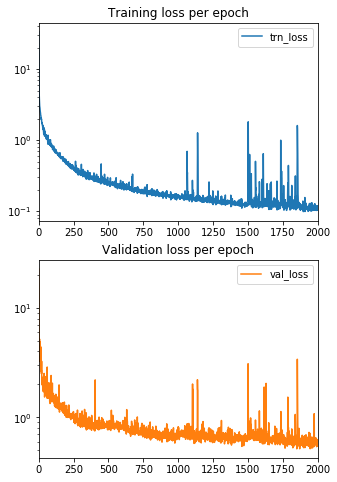

In [10]:
df_trn_loss = pd.DataFrame({
    'trn_loss': trn_loss_vals,
    'val_loss': val_loss_vals
})
_ = df_trn_loss.plot(
    y=['trn_loss', 'val_loss'],
    title=['Training loss per epoch', 'Validation loss per epoch'],
    subplots=True,
    figsize=(5,8),
    sharex=False,
    logy=True
)

### Evalute fit

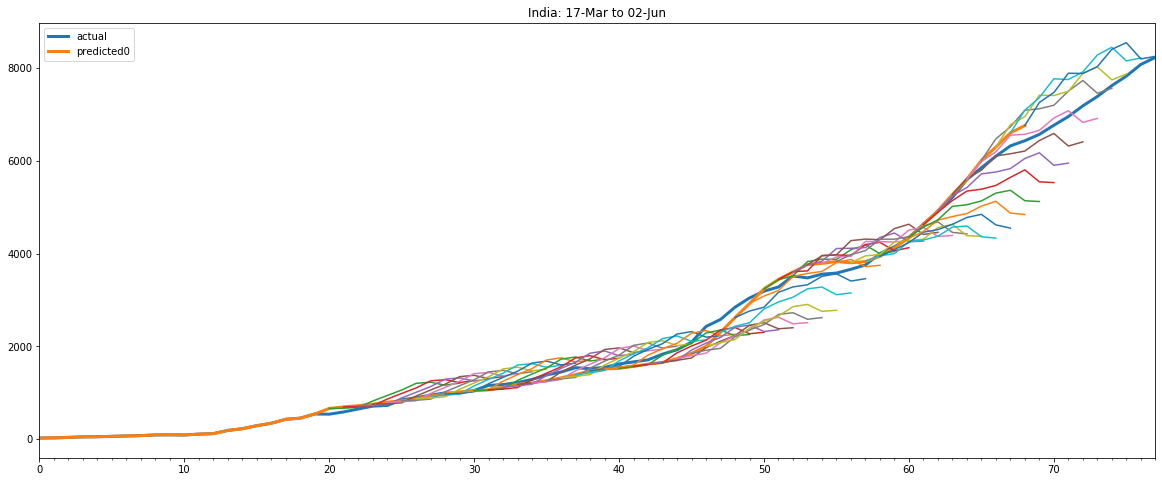

In [11]:
c = "India"
pop_fct = df.loc[df.location==c, 'population'].iloc[0] / 1000

all_preds = []
pred_vals = []
out_vals = []

test_data = np.array(df.loc[(df.location==c) & (df.total_cases>=100), 'new_cases'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

for i in range(len(test_data) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
    ip = torch.tensor(test_data[i : i+IP_SEQ_LEN])
    op = torch.tensor(test_data[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])
    ip = ip.to(device)
    op = op.to(device)

    pred = model.predict(ip.view(IP_SEQ_LEN, 1, 1))    
    if i==0: # prepend first input
        pred_vals.extend(ip.view(IP_SEQ_LEN).cpu().numpy() * pop_fct)
        out_vals.extend(ip.view(IP_SEQ_LEN).cpu().numpy() * pop_fct)        
    all_preds.append(pred.view(OP_SEQ_LEN).cpu().numpy() * pop_fct)
    pred_vals.append(pred.view(OP_SEQ_LEN).cpu().numpy()[0] * pop_fct)
    out_vals.append(op.view(OP_SEQ_LEN).cpu().numpy()[0] * pop_fct)

# last N-1 values
out_vals.extend(op.view(OP_SEQ_LEN).cpu().numpy()[1:] * pop_fct)
pred_vals.extend(([np.NaN] * OP_SEQ_LEN)[1:]) # pad with NaN

cmp_df = pd.DataFrame({
    'actual': out_vals,
    'predicted0': pred_vals
})

# plot primary lines
start_date = df.loc[(df.location==c) & (df.total_cases>=100)]['date'].iloc[0]
end_date = start_date + dt.timedelta(days=cmp_df.index[-1])
ax = cmp_df.plot(
    figsize=(20,8),
    lw=3,
    title=c + ': ' + start_date.strftime("%d-%b") + ' to ' + end_date.strftime("%d-%b")
)
mn_l = MultipleLocator(base=1)
ax.xaxis.set_minor_locator(mn_l)

# plot noodles
i=IP_SEQ_LEN
for pred in all_preds:
    cmp_df['predicted_cases'] = np.NaN
    cmp_df.loc[i:i+OP_SEQ_LEN-1, 'predicted_cases'] = pred
    cmp_df.plot(y='predicted_cases', ax=ax, legend=False)
    i+=1

### Test (predict)

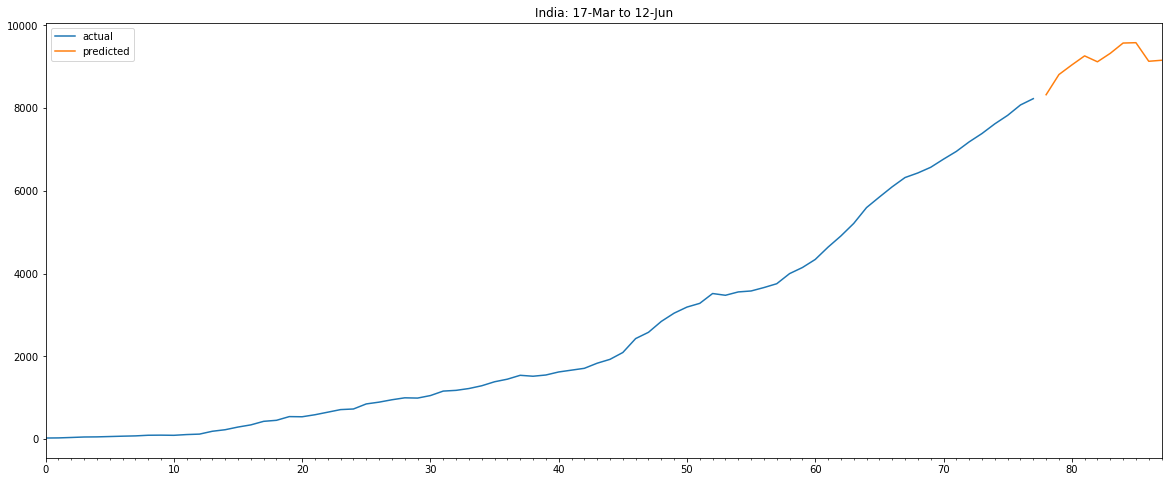

In [12]:
c = "India"
pop_fct = df.loc[df.location==c, 'population'].iloc[0] / 1000
test_data = np.array(df.loc[(df.location==c) & (df.total_cases>=100), 'new_cases'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

ip = torch.tensor(
    test_data[-IP_SEQ_LEN:],
    dtype=torch.float32
)
ip = ip.to(device)
pred = model.predict(ip.view(IP_SEQ_LEN, 1, 1))
orig_df = pd.DataFrame({
    'actual': test_data * pop_fct
})
fut_df = pd.DataFrame({
    'predicted': pred.cpu().numpy() * pop_fct
})
orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)

start_date = df.loc[(df.location==c) & (df.total_cases>=100)]['date'].iloc[0]
end_date = start_date + dt.timedelta(days=orig_df.index[-1])
ax = orig_df.plot(
    title=c + ': ' + start_date.strftime("%d-%b") + ' to ' + end_date.strftime("%d-%b"),
    figsize=(20,8)
)
mn_l = MultipleLocator(base=1)
ax.xaxis.set_minor_locator(mn_l)